In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import clear_output
import copy
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [16]:
import sys
sys.path.append("../pyfiles/")
from util import MinMax, weights_init, cuda2numpy, do_test, plot_confusion_matrix, image_from_output
from util_assignment import Dataset_Fashion_MNIST, transform, Flatten

# Introduction
---
課題は、データセットの実装とモデルの構造定義から構成されています。
その中でも後者の課題をこのノートブックで行います。
空欄を埋めて提出してください。
この課題では授業で用いた [fashion_dataset1](https://drive.google.com/drive/folders/1pX48el14cR6TY6Wor2e1Smo5cDDoQ_MK?usp=sharing)を使うので、ダウンロードしておいてください。

---
Your assignment includes dataset implementation and model structuring. This notebook contains a form of the model-structuring homework, so please submit this notebook for evaluation. It requires [fashion_dataset1](https://drive.google.com/drive/folders/1pX48el14cR6TY6Wor2e1Smo5cDDoQ_MK?usp=sharing), the same dataset used in the lesson dataset, so please visit and download it.

---

In [3]:
class_labels = ["T-shirt", "Trouser", "Dress", "Coat", "Sandal", "Sneaker", "Bag", "Ankle_boot"]
root = "../fashion_dataset1/"
classes = range(len(class_labels))

# Homework 2: Structure Modification
---
この課題では、新しい仕様書を用いてモデルの構造を変更してもらいます。
授業と異なる部分は斜め文字になっています。
このセルから下の２つが変更対象で、変更箇所は強調してあります。
`01_classification.ipynb`を参考にして頑張ってください。

---
In this homework, you are tasked with modifying the structure of the model as shown in new instruction below. The changes from the previous instruction are written in an italic style. Two cells are the only cells you need to modify and I underscored the parts you should change or add. Please refer to the lesson notebook `01_classification.ipynb` for some clues.

---

## Model Instruction
---
以下のダイアグラムと手順を元に作ってみましょう。

<img src="./../data/images/cnn.png" width="800">

- モデルは３つのconvolutional blocksと*2つ*の全結合層でできています。
- convolutional blocksは畳み込み層と*アベレージ*プーリングレイヤーでできています。
- 活性化関数として、Tanhが用いられています。
- もちろん、分類タスクなのでsoftmax関数が最後の処理として加えられています。

---
The instruction is shown below in a form of a diagram and a procedure. 

<img src="./../data/images/cnn.png" width="800">


- the model consists of 3 convolutional blocks and *2* fully connected layers.
- each convolutional block has a convolutional layer and a *averaged* pooling layer.
- *Tanh* is employed as an activation function.
- Of course, this is classification task, so you should use Softmax function in the last computation.


the image is from [this site](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

---

In [4]:
class ConvolutionalBlock(nn.Module):
    
    def __init__(self, nch_in, nch_out, kernel):
        super(ConvolutionalBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(nch_in, nch_out, kernel_size=kernel, stride=1, padding=int((kernel-1)/2)),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ------------- put activation function------------------ #
            nn.Tanh()
            #------ ------------------------------------------------- #
        )
        
    def forward(self, x):
        return self.layers(x)

In [5]:
class Classifier(nn.Module):
    
    def __init__(self, in_nch, out_nch, nch, kernel=3):
        super(Classifier, self).__init__()
        
        # ------------- define the model ------------------ #
        
        self.conv_layers = nn.Sequential(
            ConvolutionalBlock(in_nch, nch, kernel),
            ConvolutionalBlock(nch, nch*2, kernel),
            ConvolutionalBlock(nch*2, nch*4, kernel),
        )
        self.fcs = nn.Sequential(
            Flatten(),
            nn.Linear(4*4*(nch*4), 400),
            nn.Linear(400, out_nch),
            nn.Softmax()
        )
        
        # ------------------------------------------------- #
        
    def forward(self, x):
        # ------------- define the training process  ------------------ #
        
        x = self.conv_layers(x)
        x = self.fcs(x)
        
        # ------------------------------------------------------------- #
        return x

---
次に訓練用とモデル構造用のハイパーパラメタを定義していきましょう。

---
Some hyperparameters for training are mentioned in the first cell and for the model are shown in the second cell.

---

In [6]:
epoch_num = 301
lr = 0.001
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
in_nch = 1 # the number of color channels
out_nch = len(classes) # the number of output channels, in this case, classes
nch = 16

---
最適化関数、損失関数、そしてスケジューラは以下のを用いました。
- optimizer: Adam optimizer, デフォルトのパラメタ
- scheduler: 学習率が指数関数的に減少するスケジューラ
- loss function: Cross Entropy Loss (CELoss)

---
Some algorithms are employed: optimization, loss function, and scheduler.
- optimizer: Adam optimizer with default parameters
- scheduler: learning rate scheduler which lowers the lr exponentially
- loss function: Cross Entropy Loss (CELoss)

---

In [8]:
net = Classifier(in_nch, out_nch, nch)
net = net.to(device)
net.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

---
データセットを呼び出しましょう。`Dataloader`とはデータをバッチサイズにまとめてくれて、必要であればシャッフルしてくれます。

---
This is the preparation of the dataset. `Dataloader` combines the individual data to make batch-sized data and it shuffles them if you want.

---

In [9]:
# ----- adjustable parameters ----- #
each_data_num = 2000
train_batch = 512
val_batch = 512
# --------------------------------- #

dataset = Dataset_Fashion_MNIST(root, classes, "train", transform["train"], each_data_num=each_data_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_Fashion_MNIST(root, classes, "val", transform["train"], each_data_num=each_data_num)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=True)
len(dataset), len(valset)

(11200, 2400)

# Classification
---
Let's train your model.
The notebook shows you the losses and the accuracies in every epoch.
What's more, it'll store the best epoch for the validation dataset, so you can call it when the training is finished.
I highly recommend to use your GPU to quicken the process.

---

# Classification
---
では、訓練してみましょう。
このセルにはエポックごとのロスと正解率を出すようにしてます。
そして、検証用データにおいての一番いいエポックを記憶するようにしているので、後に呼び出してみましょう。
早く訓練を終わらせるためにGPUの使用をおすすめします。

---
Let's train your model.
The notebook shows you the losses and the accuracies in every epoch.
What's more, it'll store the best epoch for the validation dataset, so you can call it when the training is finished.
I highly recommend to use your GPU to quicken the process.

---

300
test acc in 300 : 0.95875
best acc is   : 0.9591666666666666 in epoch156


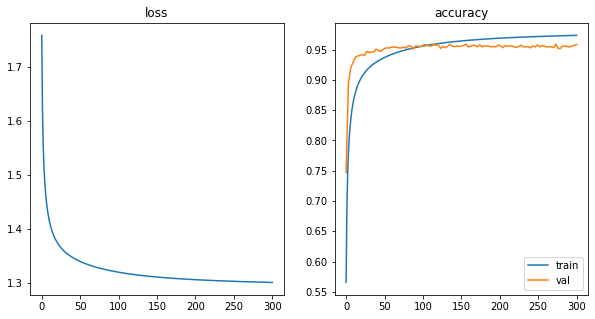

In [10]:
net.train()
losses = []
losses_epoch = []
accs = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        loss = cuda2numpy(loss)
        label = cuda2numpy(label)
        y = cuda2numpy(y)
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    scheduler.step()
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    if epoch%test_interval==0:
        labels, outputs = do_test(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.state_dict(), 
                       f"../instant_parameters/classifier_assignment_nch{nch}_lr{lr}_epoch{epoch}.pth")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

## Result
---
では出力結果をみて、一番いいエポックを確認してみましょう。
そのあと、`load_epoch`に代入してください。

---
Ok, next, please look at the output of the last cell and note the best epoch as illustrated below. 
And put the epoch into `load_epoch` in the cell below.

<img src="./../data/images/result.png" width="600">


---

In [11]:
# ----- adjustable parameters ----- #
load_epoch = 156
# --------------------------------- #

load_parameter = True
if load_parameter:
    model_path = f"../instant_parameters/classifier_assignment_nch16_lr0.001_epoch{load_epoch}.pth"
    model = torch.load(model_path)
    net.load_state_dict(model)

In [12]:
# ----- adjustable parameters ----- #
test_batch = 512
# --------------------------------- #

testset = Dataset_Fashion_MNIST(root, classes, "test", transform["test"], each_data_num=each_data_num)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=train_batch, shuffle=False)
len(testset)

2400

In [13]:
# ----- adjustable parameters ----- #
test_num = 10
# --------------------------------- #

acc_list = []
cm_list = []
for i in range(test_num):
    print(i)
    labels, outputs = do_test(net, testloader, device, "eval")
    pred_labels = np.argmax(outputs, axis=1) 
    acc_test = accuracy_score(labels, pred_labels)
    acc_list.append(acc_test)
    cm = confusion_matrix(labels, pred_labels, labels=np.arange(len(classes)))
    cm_list.append(cm)
    clear_output(wait=True)
print(f"test acc is : {np.mean(acc_list)}")

test acc is : 0.9479166666666666


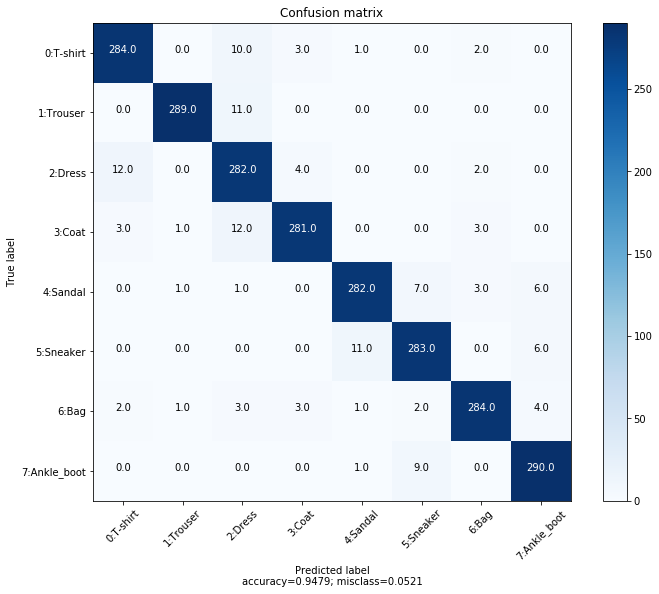

In [14]:
class_idx_lbl = class_labels.copy()
for i in range(len(class_labels)):
    class_idx_lbl[i] = f"{i}:{class_labels[i]}"
        
cm = np.mean(np.array(cm_list), axis=0)
plot_confusion_matrix(cm, class_idx_lbl, normalize=False)

## Misclassification

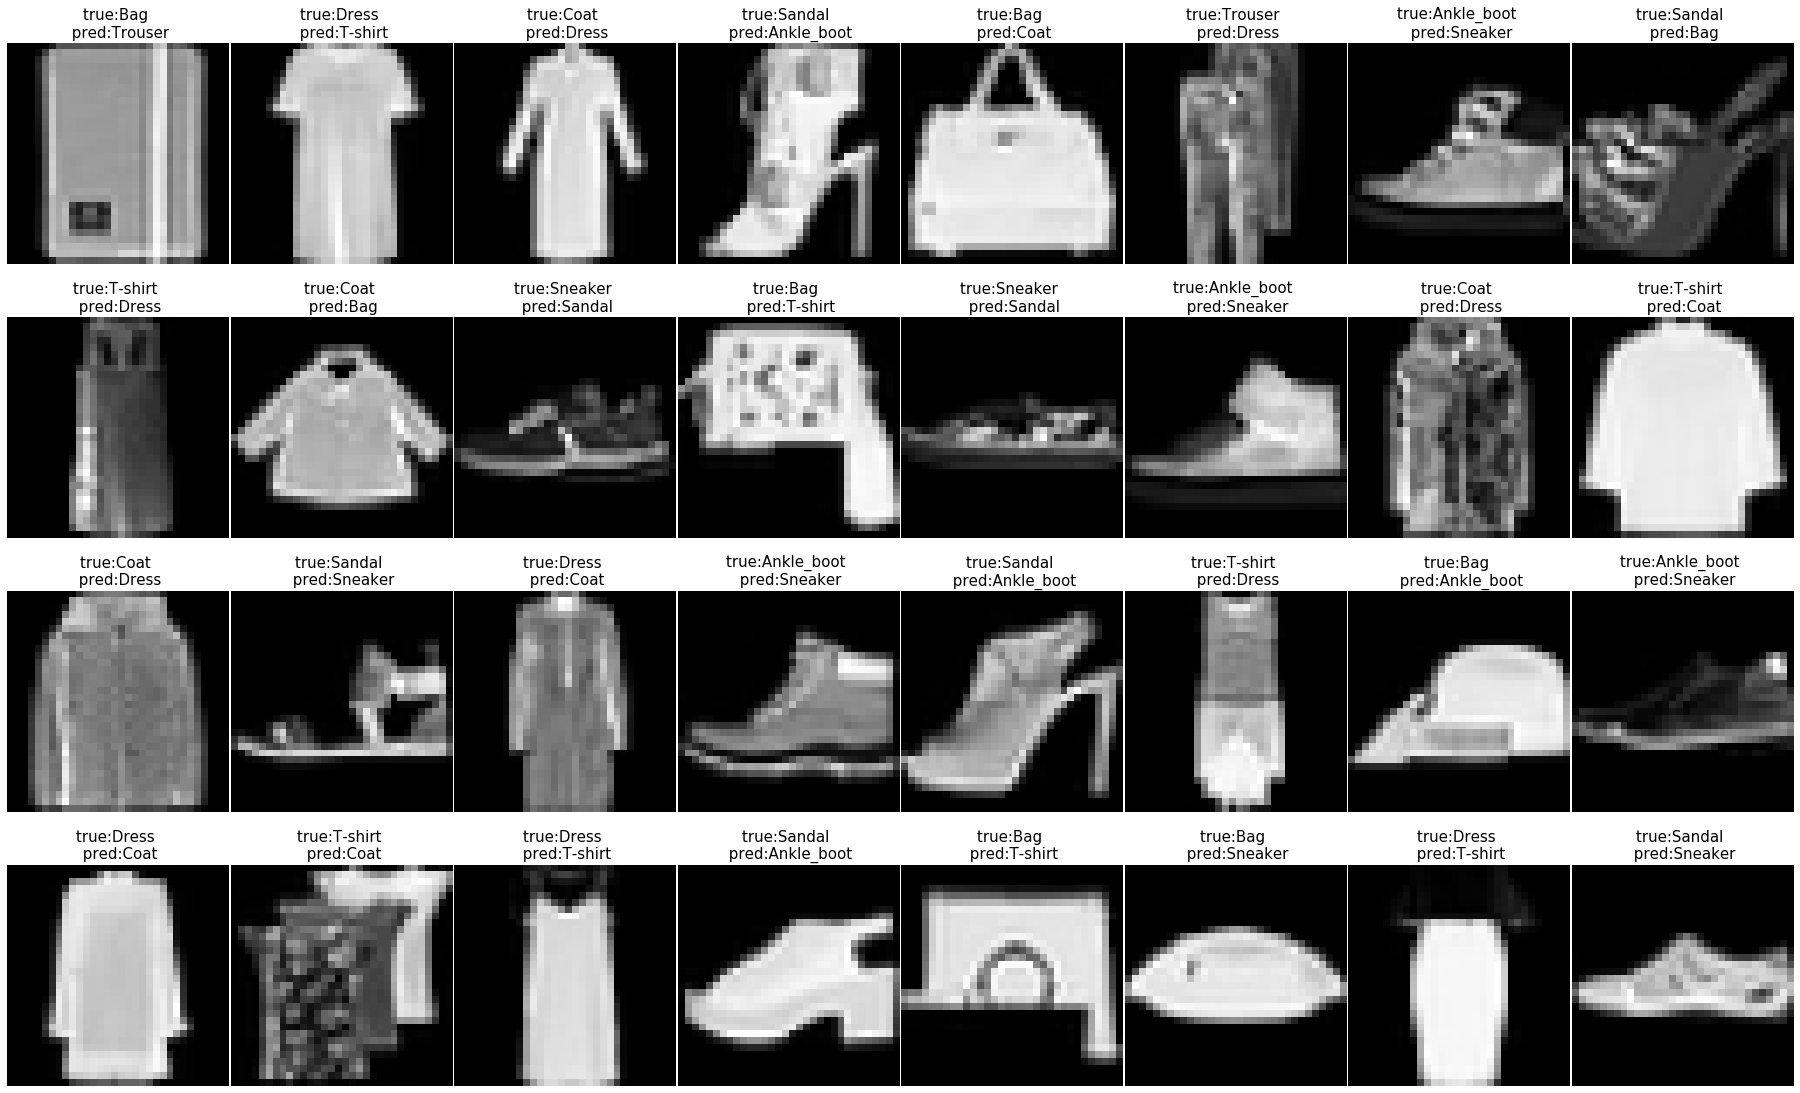

In [17]:
# ----- adjustable parameters ----- #
width = 8
length = 4
# --------------------------------- #

index_bool = pred_labels!=labels
indexes = np.random.choice(np.arange(len(labels))[index_bool], size=min(width*length,index_bool.sum()), replace=False)

fig = plt.figure(figsize=(4*width, 5*length))
for i in range(len(indexes)):
    idx = indexes[i]
    ax = fig.add_subplot(length, width, i+1)
    x, label = testset[idx]
    ax.imshow(image_from_output(x[np.newaxis])[0])
    title = f"true:{class_labels[int(labels[idx])]} \n pred:{class_labels[pred_labels[idx]]}"
    ax.set_title(title, fontsize=15)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

Please run the code until this cell
---